Date: 25/10/2019

Version: 2.0

Environment: Python 3.6.5 and Jupyter notebook

Libraries used: 
* pandas (for dataframe, included in Anaconda Python 3.6.5) 
* re (for regular expression, included in Anaconda Python 3.6.5) 
* shapely (NetworkX is a Python package for the networks function)
* sklearn.linear_model (Ordinary least squares Linear Regression)
* contextlib (for common tasks involving the with statement)
* tqdm (Progress bar)
* numpy (for scientific computing with Python)
* datetime
* seaborn (for visualization)
* shapefile
* Polygon (finding Boundary)
* patches
* PatchCollection

In [1]:
import os
os.environ["PROJ_LIB"] = "C:\\ProgramData\\Anaconda3\\pkgs\\proj4-5.2.0-h6538335_1006\\Library\\share"
from mpl_toolkits.basemap import Basemap #mapping

from shapely.geometry import Point #to find suburb
from shapely.geometry.polygon import Polygon #to find suburb 

import pandas as pd #pandas tables
import numpy as np #numpy for linear algrebra solution
import matplotlib.pyplot as plt #EDA
%matplotlib inline
pd.set_option('display.max_rows', 500) #display of pandas
pd.set_option('display.max_columns', 500)  #display of pandas
pd.set_option('display.width', 1000)  #display of pandas

import math #math operations
from datetime import datetime #datetime manipulation

import tqdm #progress bar
from tqdm import tqdm_notebook as tqdm #progress bar
from tqdm.autonotebook import tqdm #progress bar
 #progress bar

from sklearn import linear_model  #linear regression 
import statsmodels.api as sm #linear regression 

import re #regex
from contextlib import suppress #suppress error

tqdm.pandas()
import datetime as dt #to convert datetime value later on

import matplotlib 
%matplotlib inline
import shapefile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon

from shapely.geometry import Point #mapping lat long on map
from shapely.geometry.polygon import Polygon #create suburb boundary

from urllib.request import urlopen as uReq # scraping
from bs4 import BeautifulSoup as soup # Beautiful soup

# for data reshaping
import seaborn as sns #visualization
import scipy.stats as stats
import pylab 
from scipy.stats.stats import pearsonr #correlation

# testing the performance of linear model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler #standardization
from sklearn.metrics import r2_score

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
#save the columns for the output.
ori_col = ["ID",
         "Address",
         "Suburb",
         "Price",
         "Type",
         "Date",
         "Rooms",
         "Bathroom",
         "Car",
         "LandSize",
         "Age",
         "Latitude",
         "Longitude",
         "train_station_id",
         "distance_to_train_station",
         "travel_min_to_CBD",
         "over_priced?",
         "crime_A_average",
         "crime_B_average",
         "crime_C_average",
          "closest_primary_school",
          "distance_to_closest_primary",
          "primary_school_ranking",
          "closest_secondary_school",
          "distance_to_closest_secondary",
          "secondary_school_ranking"]
residents = pd.read_csv('property.csv')
#change the name of the column according to the specs
residents.rename(columns = {"Landsize":"LandSize",
                            "Lattitude":"Latitude",
                            "Longtitude":"Longitude"},
                 inplace = True)

#Initiate the columns for later purposes.
residents['Suburb'] = 'not available'
residents['train_station_id'] = -1
residents['distance_to_train_station'] = -1.
residents['travel_min_to_CBD'] = -1.
residents['over_priced?'] = -1
residents['crime_A_average'] = -1.
residents['crime_B_average'] = -1.
residents['crime_C_average'] = -1.
residents['closest_primary_school'] = 'not available'
residents['distance_to_closest_primary'] = -1.
residents['primary_school_ranking'] = -1
residents['closest_secondary_school'] = 'not available'
residents['distance_to_closest_secondary'] = -1.
residents['secondary_school_ranking'] = -1

# I. Data Integration

## I.1 Suburbs

We can get the suburbs for each resident as follow:
   * 1.1. Remove the duplicates
   * 1.2. Loop through each suburb in recs, find if the surburb is within the boundary Polygon(points)
   * 1.3. From the record of shapefile, we can get the name of the suburb from the seventh value of each record. Therefore, we will define a function that returns the suburb. 

We will read shapefile. Records and shapes in shapefile contain data and the boundary of suburbs. 

In [3]:
sf = shapefile.Reader("VIC_LOCALITY_POLYGON_shp") # all 3 files are used
recs = sf.records()
shapes = sf.shapes()

print('There are {} row in the data'.format(len(residents)))
print('There are {} records in the data'.format(len(residents['ID'].unique())))

residents[residents['ID'] == 'ID119650571']

There are 720 row in the data
There are 684 records in the data


,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,LandSize,Age,Latitude,Longitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closest_secondary,secondary_school_ranking
22,ID119650571,7B Hargreaves St,3,h,2725000.0,13/05/2017,2.0,1.0,0.0,119.0,-37.8007,144.9833,not available,-1,-1.0,-1.0,-1,-1.0,-1.0,-1.0,not available,-1.0,-1,not available,-1.0,-1
132,ID119650571,7B Hargreaves St,3,h,2725000.0,13/05/2017,2.0,1.0,0.0,119.0,-37.8007,144.9833,not available,-1,-1.0,-1.0,-1,-1.0,-1.0,-1.0,not available,-1.0,-1,not available,-1.0,-1


In [4]:
#remove duplicated values
residents = residents.drop_duplicates().reset_index(drop=True)

From shape data we have points, that show the boundary of the suburbs. In order to connect points, we will need Polygon.

In [5]:
def get_suburb(long, lat):
    
        """
        Return the name of the suburb if the geolocation is to be found
        within the boundary of the suburbs (calculated using Polygon method)
        Input is longitude, lattitude.
        Output is name.
        """
        
        property_geoloc = Point(long, lat)
        # Check if location is within suburb and edit data frame accordingly. 
        
        for index_shape, shape in enumerate(shapes):
            # get suburb boundary
            suburb_boundary = Polygon(shape.points)
                   
            if property_geoloc.within(suburb_boundary):
                #name of the suburb
                return recs[index_shape][6] 
                
                #Terminate the loop
                break

#get suburb name
residents['Suburb'] = residents[['Longitude','Latitude']].progress_apply(lambda x: get_suburb(*x), axis = 1)

## I.2. Train stations with trips leading to Southern Cross every weekday (from 7:00-9:30)

We will read data from gtfs.

In [6]:
class ptv():  
    def __init__(self, link):
        # read all at once
        self.agency = pd.read_csv(link+"/agency.txt")
        # calendar
        self.calendar = pd.read_csv(link+"/calendar.txt")
        # calendar_dates
        self.calendar_dates = pd.read_csv(link+"/calendar_dates.txt")
        # routes
        self.routes = pd.read_csv(link+"/routes.txt")
        # shapes
        self.shapes = pd.read_csv(link+"/shapes.txt")
        # stops
        self.stops = pd.read_csv(link+"/stops.txt")
        # stop_times
        self.stop_times = pd.read_csv(link+"/stop_times.txt")
        # trips
        self.trips = pd.read_csv(link+"/trips.txt")

According to the GTFS Release http://data.ptv.vic.gov.au/downloads/PTVGTFSReleaseNotes.pdf:

The PTV GTFS data has been exported by operational branches listed in the folder numbers below:  
 
* 1 - Regional Train

* 2 - Metropolitan Train 

* 3 - Metropolitan Tram 

* 4 - Metropolitan Bus 

* 5 - Regional Coach 

* 6 - Regional Bus 

* 7 - TeleBus 

* 8 – Night Bus 

* 10 - Interstate 

* 11 - SkyBus

We only need the __Train__ services information, which is stored in gtfs 1, and 2. 

In [7]:
# Regional Train
data_r = ptv("gtfs/1/google_transit")
# Metropolitan Train
data_m = ptv("gtfs/2/google_transit")
# data_list contain data from Regional Train and Metro
data_list = [data_r,data_m]

In [8]:
data_r.stop_times['arrival_time'].unique().max()

'26:18:00'

From the max of time above, we can see that the hour time can be larger than 23. The reason is because the arrival time is the continuation from the previous day, so we will need to convert the time back to the normal hour [00:00:00 - 23:59:59]

In [9]:
def fix_hour(string):
    # fix the column 24:00:00, begininning of the day
    time = list(map(int, string.split(":")))
    if time[0] > 23:
        # if time is 24 then it should change to zero
        time[0] = time[0] - 24
    return dt.time(*time)

#convert arrival time and departure time to time value
for dat in tqdm(data_list):
    dat.stop_times["arrival_time"] = dat.stop_times["arrival_time"].apply(fix_hour)
    dat.stop_times["departure_time"] = dat.stop_times["departure_time"].apply(fix_hour)

To find the closest train station (__stop_id__). We will need to do the following for both metro and regional line:

1. Find the __service__ that run every weekday 
2. From all the __service id__ that run every weekday, we find all the __trip_id__ lead to Southern Cross Station (by looking at all __stop_id__ that the trip travels through) that:

    * Depart Between 7:00am and 9:30am.
    
    * Either lead to or at the Southern Cross station (stop_id 20043 for regional, 22180 for metro)

    * If the trip ends at Southern Cross sstation, calculate the duration of the trip __(arrival time - departure time)__
    
    * If at that very same stop, more than one trip leading to Souther Cross, the __average__ time is calucated (minutes)
    
    * Store the average time to Southern Cross of each stop in a dictionary (__met_SC_times__, __reg_SC_times__)
4. For each residential property, find the __arc length__ (arc_distance function) to the closest __train station__. There will be stations that have two stop_ids, eg: Southern Cross. . PTV has two different stop IDs for the same station, one for their metro network, and one for their regional network. What our finding is that the regional network overlapping metro network. Therefore, we decided to suggest the metro stop_id to the residential properties that are close to these stations, we will use stop_id in file gtfs 2 (Metropolitan Train),

In [10]:
data_r.calendar.head()

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,UR,0,0,0,1,0,0,0,20190509,20190509
1,T6,0,0,0,0,1,0,0,20190510,20190510
2,T2,0,0,0,0,0,1,0,20190511,20190511
3,UJ,0,0,0,0,0,0,1,20190512,20190512
4,UO,1,0,0,0,0,0,0,20190513,20190513


From the table calendar above, we can see that if the trip __available__ for the day, that day will have value of __1__, otherwise __0__. 

In [11]:
def get_weekday_trips(dat):
    """
    Loop through the calendar, and find all the service_id that
    operate every weekday, return the trip_ids of all the trip
    belong to these services.
    Input: data from gtfs
    Output: list of weekday trips
    """
    # initiate the list contains the trips running every weekday
    to_sc_ids = []
    for index, loc in dat.calendar.iterrows():
            # if the trip runs five days, then the sum of these
            # column will be equal 5, we will check the sum via
            # weekday_carlendar variable, and check against 5
            weekday_carlendar = sum([dat.calendar.at[index, "monday"],
                                     dat.calendar.at[index, "tuesday"],
                                     dat.calendar.at[index, "wednesday"],
                                     dat.calendar.at[index, "thursday"],
                                     dat.calendar.at[index, "friday"]])

            if  weekday_carlendar == 5:
                # If trip available each day, append to list to_sc_ids
                to_sc_ids.append(dat.calendar.at[index, "service_id"])
            # keeping only unique trip    
            to_sc_ids = list(set(to_sc_ids))
    weekday_trips = set() # initiate weekday trips
    # after getting all service that operate every weekday, we collect the 
    # trip ids of these services and store in the variable weekday_trips
    trips = set(dat.trips[dat.trips["service_id"].isin(to_sc_ids)]["trip_id"])
    weekday_trips.update(trips)
    return weekday_trips

In [12]:
# get metro trips that run every weekday
metro_trips = get_weekday_trips(data_m)
# get regional trips that run every weekday
regional_trips = get_weekday_trips(data_r)

From here we have the list of the __trips__ that run to Southern Cross during weekdays.

In [13]:
data_r.stops[data_r.stops['stop_name'] == 'Southern Cross Railway Station (Melbourne City)']

,stop_id,stop_name,stop_lat,stop_lon
7,20043,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525


In [14]:
data_m.stops[data_m.stops['stop_name'] == 'Southern Cross Railway Station (Melbourne City)']

,stop_id,stop_name,stop_lat,stop_lon
210,22180,Southern Cross Railway Station (Melbourne City),-37.817936,144.951411


So Southern Cross Railway Station have two stop_ids, 22180 (Metro Train) and 20043 (Regional Train).

In [16]:
met_SC_times = {22180:0} # Time from Souther Cross to Southern Cross is zero
reg_SC_times = {20043:0} # Time from Souther Cross to Southern Cross is zero
def get_sc_time(data,To_SC_times,weekday_trips):
    """
    Input: data for metro or regional, times of metro
    """
    # loop through each row in data, and look at the stop_id
    for stop in tqdm(list(data.stops["stop_id"])):

        # Find trips for that stop and trips to Southern Cross 
        # Station, the trip must have the destination to Southern Cross,
        # trip available each weekday, and start from 7:00 to 9:30
        # or the stop is actually at 22180, or 20043. 
        weekday_sc_trips = data.stop_times[((data.stop_times["trip_id"].isin(weekday_trips)) &
                                           (data.stop_times["departure_time"] <= dt.time(9,30)) &
                                           (data.stop_times["departure_time"] >= dt.time(7)) &
                                           (data.stop_times["stop_id"]==stop))|
                                           ((data.stop_times["stop_id"].isin([22180, 20043])) &
                                           (data.stop_times["trip_id"].isin(weekday_trips)))]

        # Following variables used to track time to CDB
        num_trips = 0 # number of trips
        time = 0 # total time added

        # Loop through the rest of the trip_ids in weekday_sc_trips
        # to find out if the trip leads to the destination of
        # Southern Cross Station
        trip_ids = list(set(weekday_sc_trips["trip_id"]))

        # Loop through each trip in trip_ids
        for trip in trip_ids:

            # Given the trip in trip_ids, check if the trip connected
            # to Southern Cross Station
            check_trips = weekday_sc_trips[weekday_sc_trips["trip_id"]==trip].reset_index()

            # If check_trips has more than one row, which means that 
            # there is a direct connection to Southern Cross station. 
            if len(check_trips) > 1:
                # Set dep as the time departed from given station 
                # and arr as the time ended at the Southern Cross station
                if check_trips.loc[0, "stop_id"] in [22180, 20043]:
                    # In case the station before Southern Cross
                    dep = check_trips.loc[1, "departure_time"]
                    arr = check_trips.loc[0, "arrival_time"]
                else:
                    # In case the station below Southern Cross
                    dep = check_trips.loc[0, "departure_time"]
                    arr = check_trips.loc[1, "arrival_time"]

                # Calculate time difference between departure and arrival
                time_delta = dt.datetime.combine(dt.date.today(), arr) - dt.datetime.combine(dt.date.today(), dep)

                # Only consider the if the time is larger than zero.
                if time_delta.total_seconds() >= 0:
                    num_trips += 1                        # Increment counter for number of valid trips
                    time += time_delta.total_seconds()/60  # Run tally for total time in minutes

        # If there's a valid trip, add station and it's average time to dictionary.
        if num_trips > 0:
            average_time = time / num_trips
            To_SC_times[stop] = average_time
                
    return To_SC_times
# the metro station dictionary 
met_SC_times = get_sc_time(data_m,met_SC_times,metro_trips)
# the regional station dictionary 
reg_SC_times = get_sc_time(data_r,reg_SC_times,regional_trips)

In [17]:
def distance(geoloc1, geoloc2):
    
    """
    Input: 2 tuple(lat, long)
    Output: arc distance in metres between these two geolocations with earth radius is 6378km
    """
    #long, lat of geolocation 1
    lat_1, long_1 = map(math.radians, geoloc1)
    
    #long, lat of geolocation 2
    lat_2, long_2 = map(math.radians, geoloc2)
    
    #calculate arc
    arc = math.sin(0.5*(lat_2 - lat_1)) ** 2 + math.cos(lat_1) * math.cos(lat_2) * math.sin(0.5*(long_2 - long_1)) ** 2 
    
    # calculate distance
    dist = 2 * math.atan2(math.sqrt(arc), math.sqrt(1 - arc)) * 6378 * 1000
    
    return round(dist,2)

In [18]:
# get all the stops in metro Train system that match the defined criteria
stopsm = data_m.stops[data_m.stops["stop_id"].isin(met_SC_times.keys())].reset_index(drop = True)
# get all the stops in metro Train system that match the defined criteria
stopsr = data_r.stops[data_r.stops["stop_id"].isin(reg_SC_times.keys())].reset_index(drop = True)
# Iterate over each property
for row in tqdm(range(len(residents))):
    
    prop_loc = (residents.loc[row, "Latitude"], residents.loc[row, "Longitude"])  # Position for propertyy

    # Initiate the first station_id as the nearest station
    nearest_id = stopsm.loc[0, "stop_id"]
    sta_loc = (stopsm.loc[0, "stop_lat"], stopsm.loc[0, "stop_lon"])
    min_dist = distance(prop_loc, sta_loc)
    duration = met_SC_times[nearest_id]

    # Loop over each stop in metro system first
    for i in range(1, len(stopsm)):
        sta_loc = (stopsm.loc[i, "stop_lat"], stopsm.loc[i, "stop_lon"])
        sta_dist = distance(prop_loc, sta_loc)

        # If a closer station found
        if sta_dist < min_dist:
            min_dist = sta_dist
            nearest_id = stopsm.loc[i, "stop_id"]
            duration = met_SC_times[nearest_id]
    
    # Loop over each stop in regional system second  
    for i in range(len(stopsr)):
        sta_loc = (stopsr.loc[i, "stop_lat"], stopsr.loc[i, "stop_lon"])
        sta_dist = distance(prop_loc, sta_loc)

        # If a closer station found
        if sta_dist < min_dist:
            min_dist = sta_dist
            nearest_id = stopsr.loc[i, "stop_id"]
            duration = reg_SC_times[nearest_id]
    
    # Update the station id, distance to CBD, and distance to station.  
    residents.loc[row, "train_station_id"] = nearest_id
    residents.loc[row, "distance_to_train_station"] = min_dist
    residents.loc[row, "travel_min_to_CBD"] = round(duration,2)

## I.3. Crimes

The average of type A,B,C crime in the local government area the property belongs to, in the three years prior to selling the property as the property. For example, if a property is sold in 2016, then we  calculate the average of the crime type A for 2013, 2014 and 2015.

1. Crime data will be grouped by "year", "council", "type"
2. For each residential property, based on their council (found by suburb dictionary), we can look at average number of crime type per year for three previous year

In [19]:
# Read in council data
with open("councils.txt", 'r') as file: councils = file.readlines()
# strip the new line off
councils = [council.strip() for council in councils]
# create column year
residents["year"] = residents["Date"].apply(lambda x: x[-4:])
council_list = {} #each suburb will have corresponding council in dictionary council_list

#loop through each line in councils
for line in councils:
    #store council value
    council = line.split(":")[0].strip()
    
    # get suburbs
    suburbs = re.findall(r"'(.+?)'", line)
    
    #loop through suburbs
    for suburb in suburbs:
        council_list[suburb.upper()] = council  
#update council column        
residents['council'] = residents['Suburb'].apply(lambda x: council_list[x])

# Read crime data
crime = pd.read_excel("crimebylocationdatatable-yearending31march2016.xlsx",
                        sheet_name="Table 1", #the Table 1 sheet is where data is stored
                        skiprows=19) #The first 19 rows is blank

# Rename necessary columns for further reference
crime = crime.rename(columns={"Apr - Mar reference period":"year",
                              "Local Government Area":"council",
                              "CSA Offence Division":"type",
                              "Offence Count":"count"})

# Getting the letters for type (A,B,C)
crime["type"] = crime["type"].apply(lambda x: x[0])

#subset crime type A,B,C
crime_A = crime[crime["type"] == "A"]
crime_B = crime[crime["type"] == "B"]
crime_C = crime[crime["type"] == "C"]

#for each crime type, groupby year, council to get total value
crime_A = crime_A.groupby(by=["year", "council", "type"]).sum().reset_index()
crime_B = crime_B.groupby(by=["year", "council", "type"]).sum().reset_index()
crime_C = crime_C.groupby(by=["year", "council", "type"]).sum().reset_index()

In [20]:
# Iterate over each row and find crime average
for index, loc in tqdm(residents.iterrows(),total = len(residents)):
    
    # get year
    year = int(residents.at[index, "year"])
    
    # get crime of each type of 3 years before
    years_prior = [str(year - i) for i in range(1,4)]
    # type A
    cr_A = crime_A.loc[(crime_A["year"].isin(years_prior)) & (crime_A["council"]==residents.at[index, "council"])]["count"].mean()
    # type B
    cr_B = crime_B.loc[(crime_B["year"].isin(years_prior)) & (crime_B["council"]==residents.at[index, "council"])]["count"].mean()
    # type C
    cr_C = crime_C.loc[(crime_C["year"].isin(years_prior)) & (crime_C["council"]==residents.at[index, "council"])]["count"].mean()
        
    #Update column crime
    residents.at[index,'crime_A_average'] = round(cr_A,2)
    residents.at[index,'crime_B_average'] = round(cr_B,2)
    residents.at[index,'crime_C_average'] = round(cr_C,2)

# I.4. Over Priced?

<i> A boolean feature indicating whether or not the price of the property is higher than the median price of similar properties (with respect to bedrooms, bathrooms, parking_space, and property_type attributes) in the same suburb on the year of selling </i>

We will check if the residental propery sold price is over priced or not via steps:
1. For each property, filter all the properties in the dataset that have the same attributes of __bedroom, bathroom, Carspace, property type, suburb, year__ and calculate the mean value of all these house. 
2. Check if the average (mean) value is higher than the sold price of property, or lower than the sold price of the propety. Higher (not overprice).

In [21]:
for index, loc in tqdm(residents.iterrows(),total = len(residents)):
    # Find values for comparison
    
    # Bedroom
    bed = residents.at[index, "Rooms"]
    # Bathroom
    bath = residents.at[index, "Bathroom"]
    # Carspace
    car_space = residents.at[index, "Car"]
    # property type
    ptype = residents.at[index, "Type"]
    # suburb
    sub = residents.at[index, "Suburb"]
    # year
    year = residents.at[index, "year"]
    
    # Filter data set to the rows that have same attributes of
    # bedrooms, bathrooms, car_space, type, suburb, and year sold
    check_price = residents[(residents["Rooms"]    == bed) &\
                            (residents["Bathroom"] == bath) &\
                            (residents["Car"]      == car_space) &\
                            (residents["Type"]     == ptype) &\
                            (residents["Suburb"]   == sub) &\
                            (residents["year"]     == year)]
    
    
    # Check if the price is higher than the median price of other
    # houses with same attributes
    if residents.at[index, "Price"] > check_price["Price"].median():
        # Overprice
        residents.at[index, "over_priced?"] = 1 
    else:
        # Not overprice
        residents.at[index, "over_priced?"] = 0
        
# Update to boolean value True False        
residents["over_priced?"] = residents["over_priced?"].apply(lambda x: True if x == 1 else False)
        

# I.5 Schools Attributes.

We will need to scrape for data from Primary Schools and Secondary Schools:
* __Primary__ School Ranking can be found in here: http://www.schoolcatchment.com.au/?p=12301

* __Secondary__ School Ranking can be found in https://sites.google.com/a/monash.edu/secondary-school-ranking/

* __Integrate__ both Primary and Secondary School information into `property.csv` dataframe (named residents)
Need to use urllib.request to access website then use BeautifulSoup to scrape the websites. But it's complicated to interact with https://sites.google.com/a/monash.edu/secondary-school-ranking/ so we decide to download the contents as an html file from this url then use BeautifulSoup to parse the contents.

### I.5.1. Access [Primary School Ranking](http://www.schoolcatchment.com.au/?p=12301) and store the ranking information into a dataframe with pandas
 * obtain the following information:
    * Ranking
    * School Name
    * State
    * School Sector
    * Location
    * Total Enrolment
    * Percentage
 * store the information into a dataframe
 * keep the best ranking if the school names are the same (as required by assignment specification)
 

In [22]:
primary_rank_url = 'http://www.schoolcatchment.com.au/?p=12301'

# send request to access the url
primaryClient = uReq(primary_rank_url)
page_html = primaryClient.read()
primaryClient.close()

page_soup = soup(page_html, "html.parser")

In [23]:
infile_schools = open("schools.xml","r")
contents_schools = infile_schools.read()
schools_soup = soup(contents_schools,'xml')

# extract school name, school type, locations
schools_xml_names_container = schools_soup.findAll("School_Name")
schools_xml_names_list = []
for names in schools_xml_names_container:
    schools_xml_names_list.append(names.get_text())

schools_xml_type_container = schools_soup.findAll("School_Type")
schools_xml_type_list = []
for types in schools_xml_type_container:
    schools_xml_type_list.append(types.get_text())

# x is actually the longtitude
schools_xml_x_container = schools_soup.findAll("X")
schools_xml_x_list = []
for longtitude in schools_xml_x_container:
    schools_xml_x_list.append(longtitude.get_text())

# y is latitude
schools_xml_y_container = schools_soup.findAll("Y")
schools_xml_y_list = []
for latitude in schools_xml_y_container:
    schools_xml_y_list.append(latitude.get_text())

#### I.5.1.1 The ranking information are under 'td' tag and the following:
* column-1 contains rank
* column-2 contains school name
* column-3 contains state
* column-4 contains school sector
* column-5 contains location
* column-6 contains total enrolment
* column-7 contains percentage

In [24]:
containers_1 = page_soup.findAll("td",{"class":"column-1"})

rank_list = []
for container in containers_1:
    rank_list.append(container.get_text()) # container.get_text() returns the ranking
    
containers_2 = page_soup.findAll("td",{"class":"column-2"})

primary_school_name_list = []
for container in containers_2:
    primary_school_name_list.append(container.get_text()) # container.get_text() returns the school_name
    
    
containers_3 = page_soup.findAll("td",{"class":"column-3"})

state_list = []
for container in containers_3:
    state_list.append(container.get_text()) # container.get_text() returns the state


containers_4 = page_soup.findAll("td",{"class":"column-4"})

school_sector_list = []
for container in containers_4:
    school_sector_list.append(container.get_text()) # container.get_text() returns the school_sector
    
    
containers_5 = page_soup.findAll("td",{"class":"column-5"})

location_list = []
for container in containers_5:
    location_list.append(container.get_text()) # container.get_text() returns the location
    
containers_6 = page_soup.findAll("td",{"class":"column-6"})

enrolment_list = []
for container in containers_6:
    enrolment_list.append(container.get_text()) # container.get_text() returns the total enrolment
    

containers_7 = page_soup.findAll("td",{"class":"column-7"})

percentage_list = []
for container in containers_7:
    percentage_list.append(container.get_text()) # container.get_text() returns the percentage

In [25]:
    
# Synchronizing name between primary and schools_xml_names_list
for i in range(len(schools_xml_names_list)):
    for j in range(len(primary_school_name_list)):
        if schools_xml_names_list[i].lower() == primary_school_name_list[j].lower():
            primary_school_name_list[j] = schools_xml_names_list[i]    

In [26]:
# create primary school dataframe to store primary shcool information
column_names = ['Ranking','School Name','State','School Sector','Location','Total Enrolment','Percentage']
primary_df = pd.DataFrame(columns=column_names)

primary_df.Ranking = rank_list
primary_df['School Name'] = primary_school_name_list
primary_df['State'] = state_list
primary_df['School Sector'] = school_sector_list
primary_df['Location'] = location_list
primary_df['Total Enrolment'] = enrolment_list
primary_df['Percentage'] = percentage_list

#### I.5.1.2 There are duplicates in rankings, so we keep the highest ranking and remove the duplicates

In [27]:
primary_no_duplicate = primary_df.drop_duplicates(subset='School Name',keep='first')
primary_no_duplicate = primary_no_duplicate.reset_index(drop= True)

### I.5.2. Access [Secondary School Ranking](https://sites.google.com/a/monash.edu/secondary-school-ranking/) and store the ranking information into a dataframe with pandas
 * obtain the following information:
     * School Name
     * Ranking
     * Change
     * Median VCE Study Score
     * 40+ Study Score
 * store the information into a dataframe
 * keep the best ranking if the school names are the same (as required by assignment specification)

#### We download the https://sites.google.com/a/monash.edu/secondary-school-ranking/ to process because it would cause lots of troubles if we have to interact with the website using authenticate

* Secondary School Ranking is saved as 'secondary-school-ranking.html'

* from browsing the contents, we found that the rank information are under 'ul' tag and the contents are seperated by '\n\n\n\n' four new line characters, also that in each sinlge ranking content, the information is seperated by '\n' one single new line character. So we need to clean the body before we can extract the desired information.

In [28]:
# use beautifulsoup to read the contents in "secondary-school-ranking.html"
infile_secondary = open("secondary-school-ranking.html","r")
contents_secondary = infile_secondary.read()
secondary_schools_soup = soup(contents_secondary,'html')

In [29]:
# locate the secondary school information
ul = secondary_schools_soup.find_all('ul')

# store the school information
contents = []
for content in ul:
    contents.append(content.get_text())

# wrangle the contents, remove new lines
rank_body = contents[2].strip()
split_rank_body = rank_body.split('\n\n\n\n')

# remove new lines and seperate by coma
clean_rank_body = []
for strings in split_rank_body:
    clean_rank_body.append(strings.replace('\n', ',')) # replace the original seperator <new line character> with coma 

# display one line of the cleaned body
clean_rank_body[0]

'Academy of Mary Immaculate,144,-28,31,7.1%'

In [30]:
# create secondary_ranking dataframe to store secondary school information
column_name = ['School Name', 'Ranking', 'Change', 'Median VCE Study Score', '40+ Study Score']

secondary_ranking_df = pd.DataFrame(columns = column_name)

secondary_school_name = []
secondary_ranking = []
change = []
median_score = []
forty_plus = []
for item in clean_rank_body:
    temp = item.split(',') # seperate the information by coma
    secondary_school_name.append(temp[0])
    secondary_ranking.append(temp[1])
    change.append(temp[2])
    median_score.append(temp[3])
    forty_plus.append(temp[4])
    
secondary_ranking_df['School Name'] = secondary_school_name
secondary_ranking_df['Ranking'] = secondary_ranking
secondary_ranking_df['Change'] = change
secondary_ranking_df['Median VCE Study Score'] = median_score
secondary_ranking_df['40+ Study Score'] = forty_plus

secondary_ranking_df.head()

,School Name,Ranking,Change,Median VCE Study Score,40+ Study Score
0,Academy of Mary Immaculate,144,-28,31,7.1%
1,Adass Israel School,534,-1,N/A,N/A
2,Advance College of Education,535,-1,N/A,N/A
3,Aitken College,194,+32,30,4.8%
4,Al Siraat College,280,+172,28,5.4%


In [31]:
secondary_ranking_df = secondary_ranking_df.astype({'Ranking': 'int32'})
secondary_ranking_df = secondary_ranking_df.sort_values(by = 'Ranking')
secondary_ranking_df = secondary_ranking_df.reset_index(drop = True)

In [32]:
# remove duplicates and keep the highest ranking
secondary_no_duplicate = secondary_ranking_df.drop_duplicates(subset='School Name', keep='first')
secondary_no_duplicate = secondary_no_duplicate.reset_index(drop = True)

In [33]:
secondary_ranking_df[secondary_ranking_df['School Name'] == "Melbourne Grammar School"]

,School Name,Ranking,Change,Median VCE Study Score,40+ Study Score
13,Melbourne Grammar School,14,+28,36,27.5%


### I.5.3. Integrate Primary and Secondary School Ranking into residents dataframe (property.csv)

We need to integrate the following:
* ranking by primary and secondary schools
  * use if-else control structure to match ranking and school names
* closest primary and secondary schools
  * use priviously defined distance() function to loop through dataframe to find closest distance, keep track with dataframe index
  * then use dictionary to match the distance and the index and retrieve the school names respectively
* distance from primary and secondary schools

#### I.5.3.1 Replace html mark up with their corresponding signs

In [34]:
# return the " ' " sign from html mark up
for i in schools_soup.findAll('School_Name'):
    if i.text == "&apos;" in i.text:
        i.string = "'"
        
for i in schools_soup.findAll('Address_Line_1'):
    if i.text == "&apos;" in i.text:
        i.string = "'"

#### I.5.3.2 Extract school name,school type,  longtitude and latitude

In [35]:
# create a schools_xml dataframe in order to integrate school information obtained from websites
p_schools_xml_colnames = ['School Name', 'School Type', 'X', 'Y', 'Ranking']
p_schools_xml_df = pd.DataFrame(columns=p_schools_xml_colnames)
p_schools_xml_df['School Name'] = schools_xml_names_list
p_schools_xml_df['School Type'] = schools_xml_type_list
p_schools_xml_df['X'] = schools_xml_x_list
p_schools_xml_df['Y'] = schools_xml_y_list

s_schools_xml_colnames = ['School Name', 'School Type', 'X', 'Y', 'Ranking']
s_schools_xml_df = pd.DataFrame(columns=s_schools_xml_colnames)
s_schools_xml_df['School Name'] = schools_xml_names_list
s_schools_xml_df['School Type'] = schools_xml_type_list
s_schools_xml_df['X'] = schools_xml_x_list
s_schools_xml_df['Y'] = schools_xml_y_list

#### I.5.3.3 Integrate the ranking

In [37]:
# integrate school rankings into schools_xml dataframe
p_schools_names_dictionary = {}
s_schools_names_dictionary = {}

unique_school_name = set(schools_xml_names_list)

for name in unique_school_name:
    # integrate primary school ranking
    if name in primary_school_name_list:
        ranking = primary_no_duplicate.loc[primary_no_duplicate['School Name']==name].Ranking.values[0]
        p_schools_names_dictionary[name] = int(ranking)
    if name in secondary_school_name:
        ranking = secondary_no_duplicate.loc[secondary_no_duplicate['School Name']==name].Ranking.values[0]
        s_schools_names_dictionary[name] = int(ranking)

In [38]:
for index, row in p_schools_xml_df.iterrows():
    if p_schools_xml_df.at[index, 'School Name'] in set(p_schools_names_dictionary.keys()):
        rank = p_schools_names_dictionary[p_schools_xml_df.at[index, 'School Name']]
        p_schools_xml_df.at[index, 'Ranking'] = rank
    else:
        p_schools_xml_df.at[index, 'Ranking'] = -1
        
for index, row in s_schools_xml_df.iterrows():
    if s_schools_xml_df.at[index, 'School Name'] in set(s_schools_names_dictionary.keys()):
        rank = s_schools_names_dictionary[s_schools_xml_df.at[index, 'School Name']]
        s_schools_xml_df.at[index, 'Ranking'] = rank
    else:
        s_schools_xml_df.at[index, 'Ranking'] = -1

In [39]:
p_schools_xml_df = p_schools_xml_df[(p_schools_xml_df['School Type'] == 'Primary') | (p_schools_xml_df['School Type'] == 'Pri/Sec')]
s_schools_xml_df = s_schools_xml_df[(s_schools_xml_df['School Type'] == 'Secondary') | (s_schools_xml_df['School Type'] == 'Pri/Sec')]

#### I.5.3.4 Calculate closest distance for primary and secondary schools based on latitude and longtitude using UDF distance() function. Keep track with the dataframe index and create a dictionary based on the distance and index.

For each residential property, we can find the nearest school by arc distance. If the school does not have ranking, the ranking column is labeled as "not ranked"

In [40]:
for index, row in tqdm(residents.iterrows(), total = len(residents)):
   
    pri_closest = 999999999. #initiate the furthest values
    pri_name = ''
    pri_rank = -2
    sec_closest = 999999999.
    sec_name = ''
    sec_rank = -2
    
    location_1 = []
    location_1.append(row['Latitude'])
    location_1.append(row['Longitude'])
    
    for index_s, row_s in p_schools_xml_df.iterrows():
        location_temp = []
        location_temp.append(float(row_s['Y'])) # change the string type to float type
        location_temp.append(float(row_s['X'])) # change the string type to float type
            # finding the closest primary
        pri_dist = distance(location_1, location_temp)
        if pri_closest >= pri_dist:
            pri_closest = pri_dist
            pri_name = row_s['School Name']
            pri_rank = row_s['Ranking']

                
    for index_s, row_s in s_schools_xml_df.iterrows():
        location_temp = []
        location_temp.append(float(row_s['Y'])) # change the string type to float type
        location_temp.append(float(row_s['X'])) # change the string type to float type            
            # finding the closest secondary
        sec_dist = distance(location_1, location_temp)
        if sec_closest >= sec_dist:
            sec_closest = sec_dist
            sec_name = row_s['School Name']
            sec_rank = row_s['Ranking']

    
    residents.at[index, 'primary_school_ranking'] = pri_rank
    residents.at[index, 'closest_primary_school'] = pri_name
    residents.at[index, 'distance_to_closest_primary'] = pri_closest
    
    residents.at[index, 'secondary_school_ranking'] = sec_rank
    residents.at[index, 'closest_secondary_school'] = sec_name
    residents.at[index, 'distance_to_closest_secondary'] = sec_closest
    
# change the ranking value to 'not ranked' if the value is default value -1
def not_ranked(minusone):
    if minusone == -1:
        return 'not ranked'
    else:
        return minusone
    
residents['primary_school_ranking'] = residents['primary_school_ranking'].apply(lambda x: not_ranked(x)) 
residents['secondary_school_ranking'] = residents['secondary_school_ranking'].apply(lambda x: not_ranked(x)) 

In [41]:
# produce output to _solution
residents = residents[ori_col]
residents.to_csv('property_solution.csv', index = False)

# II. Data Reshaping

We will study the effect of different normalization/transformation methods on Rooms, crime_C_average, travel_min_to_CBD, and property_age attributes. 

## II.1. Standardization

Standarisation is also used to bring all the variables to a similar scale. Standarisation means centering the variable at zero, and standarising the variance at 1. The procedure involves subtracting the mean of each observation and then dividing by the standard deviation:

z = (x - x_mean) /  std

In [43]:
# read data from last solution.
data = pd.read_csv('property_solution.csv', usecols = ["Rooms", "crime_C_average", "travel_min_to_CBD", "Age", "Price"])

In [44]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

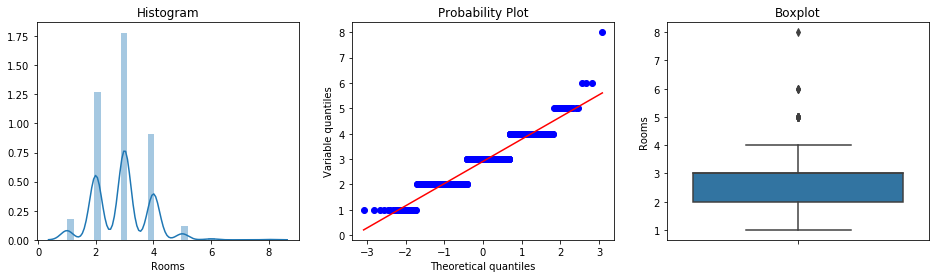

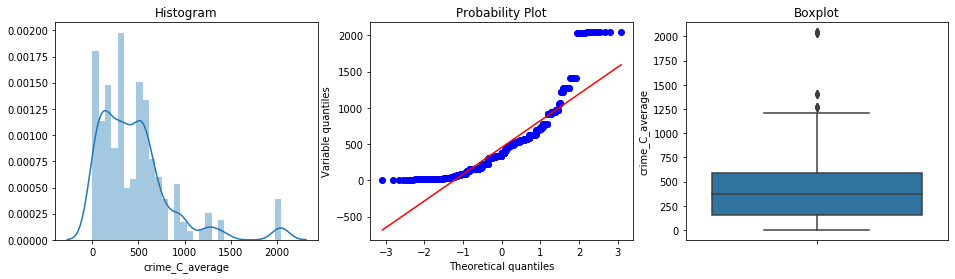

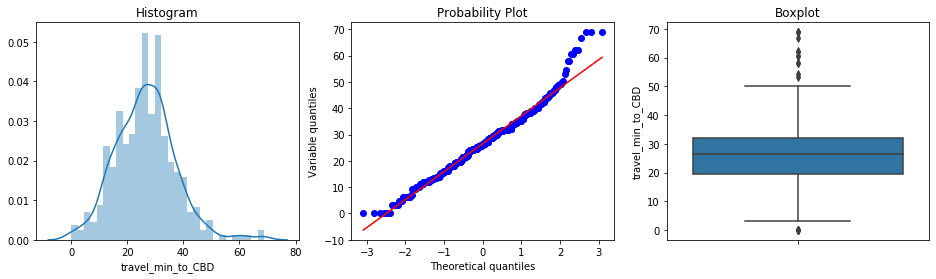

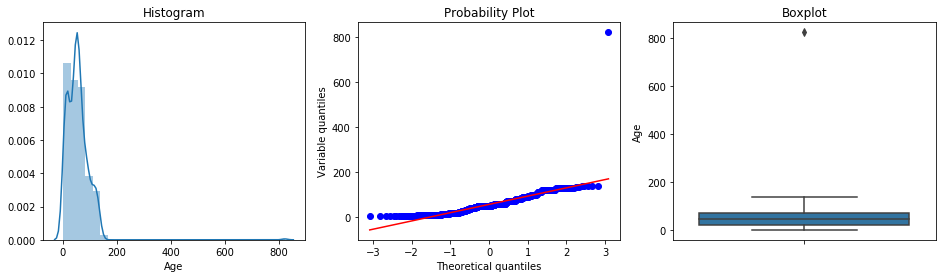

In [45]:
diagnostic_plots(data, 'Rooms')
diagnostic_plots(data, 'crime_C_average')
diagnostic_plots(data, 'travel_min_to_CBD')
diagnostic_plots(data, 'Age')

In [46]:
data.describe()

,Price,Rooms,Age,travel_min_to_CBD,crime_C_average
count,6.840000e+02,684.000000,684.000000,684.000000,684.000000
mean,1.066358e+06,2.906433,55.517544,26.518626,454.917076
std,6.257420e+05,0.926281,45.208008,10.701869,403.846943
min,1.450000e+05,1.000000,2.000000,0.000000,1.000000
25%,6.407500e+05,2.000000,24.000000,19.400000,159.330000
50%,8.950000e+05,3.000000,49.000000,26.380000,371.830000
75%,1.311250e+06,3.000000,74.000000,32.140000,586.670000
max,4.735000e+06,8.000000,823.000000,68.820000,2042.330000


__Observation__: From the diagnostic plot and data description above, we can see that the range of values in columns is highly varied. For example, crime_C_average is in hundreds, while Age is in tens. 

__Suggested Solution__: if the value of predictor is highly variance in larger scale, it will dominate the prediction of model. We will nomalize values without changing the shape of the distribution. The Price is the target variable, thus cannot affect the accuracy, we will not normalize Price.

__Normalization Methods__: standarisation or min-max(scaling):

    * standarization: the distribution will in center around zero and standard deviation is 1.
    * min_max : distribution ranging from 0 (for min) and 1 (for max)
    
For data that has max value is really high like Age, using min_max will shift most of the data towards min. Therefor min_max method will not be a good choice in this case. We will use standarisation.

(<matplotlib.axes._subplots.AxesSubplot at 0x2cae95efcc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2cae95efcc0>)

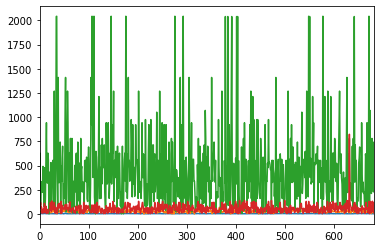

In [47]:
data["Rooms"].plot(), \
data["travel_min_to_CBD"].plot(), \
data["crime_C_average"].plot(), \
data["Age"].plot()

In [48]:
scaled_col = ["Rooms", "crime_C_average", "travel_min_to_CBD", "Age"]

In [49]:
scaler = StandardScaler()
data_noprice = data[scaled_col]
data_scaled = scaler.fit_transform(data_noprice)
data_scaled = pd.DataFrame(data_scaled, columns=data_noprice.columns)

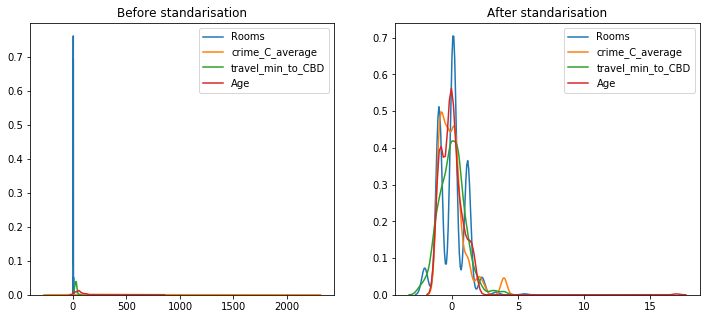

In [50]:
# let's compare the variable distributions before and after scaling

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before standarisation')
sns.kdeplot(data['Rooms'], ax=ax1)
sns.kdeplot(data['crime_C_average'], ax=ax1)
sns.kdeplot(data['travel_min_to_CBD'], ax=ax1)
sns.kdeplot(data['Age'], ax=ax1)

# after scaling
ax2.set_title('After standarisation')
sns.kdeplot(data_scaled['Rooms'], ax=ax2)
sns.kdeplot(data_scaled['crime_C_average'], ax=ax2)
sns.kdeplot(data_scaled['travel_min_to_CBD'], ax=ax2)
sns.kdeplot(data_scaled['Age'], ax=ax2)
plt.show()

## II.2. Transformation

__Transformation__: from the data above we can see that Age, crime_C_average, travel_min_to_CBD are positively skewed after being standarized. Skewed attributes will effect linear model, and thus should be transformed. 


In [51]:
# create new transformed data

# Log Transformed
data_log = pd.DataFrame()
# Square root transformed
data_sqrt = pd.DataFrame()

# crime_C_average
data_sqrt['crime_C_average'] = data['crime_C_average'].apply(lambda x: x**0.5)
data_log['crime_C_average'] = data['crime_C_average'].apply(math.log1p)

# travel_min_to_CBD
data_sqrt['travel_min_to_CBD'] = data['travel_min_to_CBD'].apply(lambda x: x**0.5)
data_log['travel_min_to_CBD'] = data['travel_min_to_CBD'].apply(math.log1p)

# Age
data_sqrt['Age'] = data['Age'].apply(lambda x: x**0.5)
data_log['Age'] = data['Age'].apply(math.log1p)

# Price
data_sqrt['Price'] = data['Price'].apply(lambda x: x**0.5)
data_log['Price'] = data['Price'].apply(math.log1p)
# Rooms
data_sqrt['Rooms'] = data['Rooms'].apply(lambda x: x**0.5)
data_log['Rooms'] = data['Rooms'].apply(math.log1p)

Pearson Correlation before transformation of crime: 0.18346048052471195
Pearson Correlation after log transformation: 0.09509391675849836
Pearson Correlation after square root transformation: 0.1449474675848826


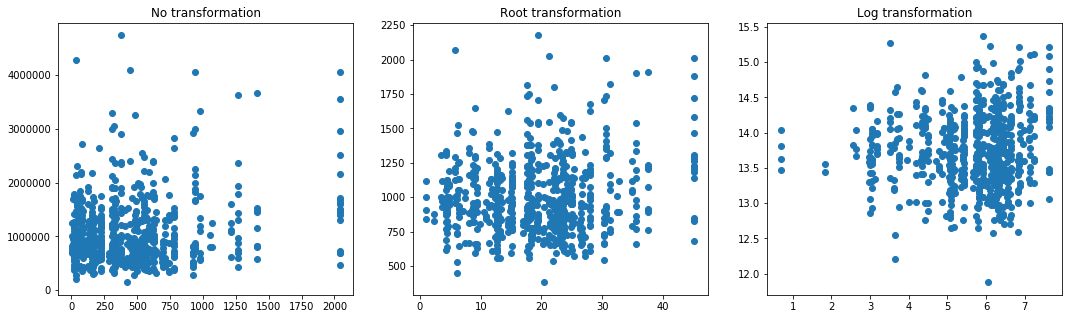

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 5))

ax1.set_title('No transformation')
ax1.scatter(data["crime_C_average"], data["Price"])
ax3.set_title('Log transformation')
ax3.scatter(data_log["crime_C_average"], data_log["Price"])
ax2.set_title('Root transformation')
ax2.scatter(data_sqrt["crime_C_average"], data_sqrt["Price"])


print('Pearson Correlation before transformation of crime: {}'.format(pearsonr(data['crime_C_average'],data['Price'])[0]))
print('Pearson Correlation after log transformation: {}'.format(pearsonr(data_log['crime_C_average'],data['Price'])[0]))
print('Pearson Correlation after square root transformation: {}'.format(pearsonr(data_sqrt['crime_C_average'],data['Price'])[0]))

For __crime_C_average__ we can get a stronger linear relationship with __Price__ after without doing transformation. 

Pearson Correlation before transformation of travel minutes: -0.15276167025247694
Pearson Correlation after square root transformation: -0.13950159962082964
Pearson Correlation after log transformation: -0.12048756002023447


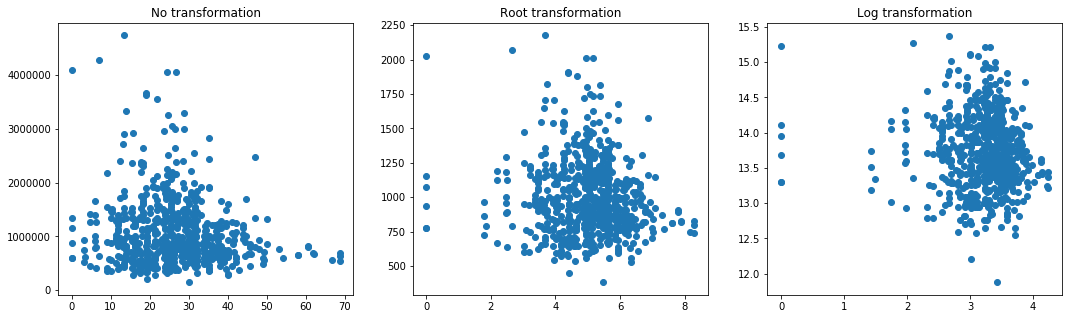

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 5))

ax1.set_title('No transformation')
ax1.scatter(data["travel_min_to_CBD"], data["Price"])
ax2.set_title('Root transformation')
ax2.scatter(data_sqrt["travel_min_to_CBD"], data_sqrt["Price"])
ax3.set_title('Log transformation')
ax3.scatter(data_log["travel_min_to_CBD"], data_log["Price"])

print('Pearson Correlation before transformation of travel minutes: {}'.format(pearsonr(data['travel_min_to_CBD'],data['Price'])[0]))
print('Pearson Correlation after square root transformation: {}'.format(pearsonr(data_sqrt['travel_min_to_CBD'],data['Price'])[0]))
print('Pearson Correlation after log transformation: {}'.format(pearsonr(data_log['travel_min_to_CBD'],data['Price'])[0]))

For __travel_min_to_CBD__ we can get a stronger linear relationship with __Price__ after without doing transformation. 

Pearson Correlation before transformation of Rooms: 0.4649864676206458
Pearson Correlation after square root transformation: 0.46647131200065145
Pearson Correlation after log transformation: 0.4648056166483289


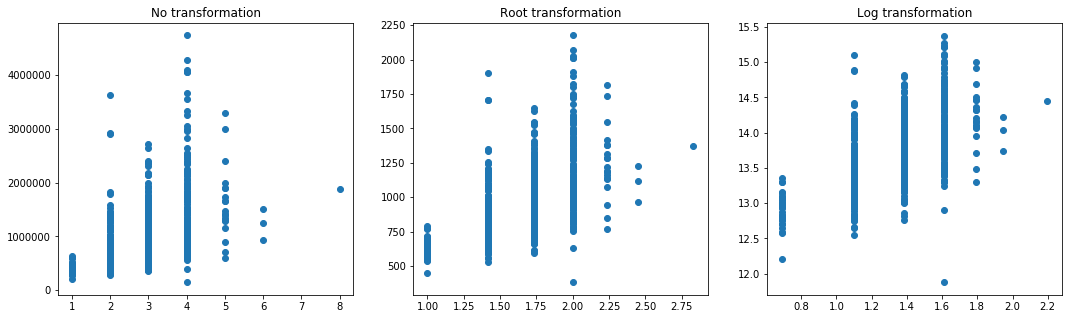

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 5))

ax1.set_title('No transformation')
ax1.scatter(data["Rooms"], data["Price"])
ax2.set_title('Root transformation')
ax2.scatter(data_sqrt["Rooms"], data_sqrt["Price"])
ax3.set_title('Log transformation')
ax3.scatter(data_log["Rooms"], data_log["Price"])

print('Pearson Correlation before transformation of Rooms: {}'.format(pearsonr(data['Rooms'],data['Price'])[0]))
print('Pearson Correlation after square root transformation: {}'.format(pearsonr(data_sqrt['Rooms'],data['Price'])[0]))
print('Pearson Correlation after log transformation: {}'.format(pearsonr(data_log['Rooms'],data['Price'])[0]))

For __Rooms__ we can get a stronger linear relationship with __Price__ after after doing square root transformation. 

Pearson Correlation before transformation of Age: 0.17318276973107696
Pearson Correlation after square root transformation: 0.19017618542541836
Pearson Correlation after log transformation: 0.15619246584707536


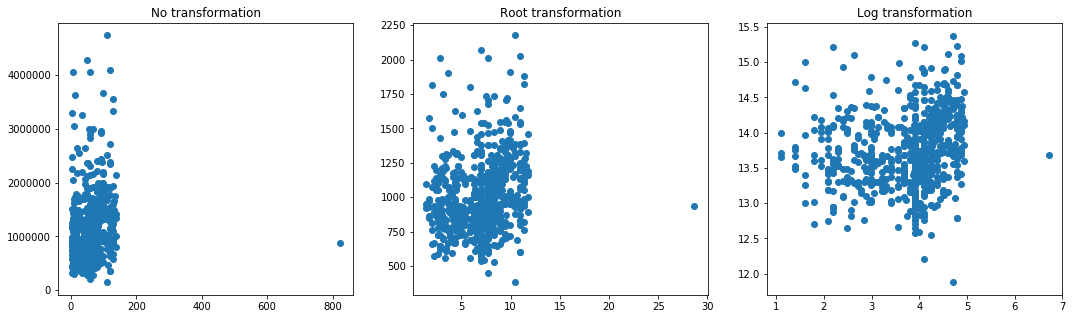

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 5))

ax1.set_title('No transformation')
ax1.scatter(data["Age"], data["Price"])
ax2.set_title('Root transformation')
ax2.scatter(data_sqrt["Age"], data_sqrt["Price"])
ax3.set_title('Log transformation')
ax3.scatter(data_log["Age"], data_log["Price"])

print('Pearson Correlation before transformation of Age: {}'.format(pearsonr(data['Age'],data['Price'])[0]))
print('Pearson Correlation after square root transformation: {}'.format(pearsonr(data_sqrt['Age'],data['Price'])[0]))
print('Pearson Correlation after log transformation: {}'.format(pearsonr(data_log['Age'],data['Price'])[0]))

For __Age__ we can get a stronger linear relationship with __Price__ after  doing square root transformation. 

__Suggested solution__: So we will not do transformation for __crime_C_average__, and __travel_min_to_CBD__, and we will do square root transforamtion for __Rooms__ and __Age__

In [57]:
#transformed data
trans = pd.DataFrame()
trans['Price'] = data['Price']
trans['Rooms'] = data_log['Rooms']
trans['crime_C_average'] = data['crime_C_average']
trans['travel_min_to_CBD'] = data['travel_min_to_CBD']
trans['Age'] = data_log['Age']

#transformed data square root
trans_sqrt = pd.DataFrame()
trans_sqrt['Price'] = data['Price']
trans_sqrt['Rooms'] = data_sqrt['Rooms']
trans_sqrt['crime_C_average'] = data['crime_C_average']
trans_sqrt['travel_min_to_CBD'] = data['travel_min_to_CBD']
trans_sqrt['Age'] = data_sqrt['Age']


#normalize data
norm = pd.DataFrame()
norm['Price'] = data['Price']
norm['Rooms'] = data_scaled['Rooms']
norm['crime_C_average'] = data_scaled['crime_C_average']
norm['travel_min_to_CBD'] = data_scaled['travel_min_to_CBD']
norm['Age'] = data_scaled['Age']

#transform and normalize data
trans_norm = pd.DataFrame()
trans_norm['Price'] = data['Price']
trans_norm['Rooms'] = data_sqrt['Rooms']
trans_norm['crime_C_average'] = data_scaled['crime_C_average']
trans_norm['travel_min_to_CBD'] = data_scaled['travel_min_to_CBD']
trans_norm['Age'] = data_sqrt['Age']

In [58]:
def testing(data,model):
    """
    This model will return the R_squared, mse, mae of linear model
    given different input data
    """
    
    X_train, X_test, y_train, y_test = train_test_split(data[["Rooms", "crime_C_average", "travel_min_to_CBD", "Age"]],
                                                        data.Price, test_size=0.3,
                                                        random_state=0)
    X = X_train
    y = y_train
    # instantiate and fit
    lm= LinearRegression()
    lm.fit(X, y)
    # print the metrics
    y_pred = lm.predict(X_test)
    print('R squared of {} : {}'.format(model,lm.score(X,y)))
    print('MSE of {} : {}'.format(model,mean_squared_error(y_test,y_pred)))
    print('MAE of {} : {}'.format(model,mean_absolute_error(y_test,y_pred)))
    return

We will test if the model accuracy is improved after transformation/standarization is made in comparison with original linear model (no transformation and no standarization)

In [59]:
testing(data,'base')

R squared of base : 0.35662821712965204
MSE of base : 217615440143.26218
MAE of base : 319970.6434809066


In [60]:
testing(norm,'standarization')

R squared of standarization : 0.35662821712965204
MSE of standarization : 217615440143.2621
MAE of standarization : 319970.64348090644


After standarization, the performance of model did not get better. We will check the log transformed model

In [61]:
testing(trans_sqrt,'transformed')

R squared of transformed : 0.36898061173905483
MSE of transformed : 218645816292.99756
MAE of transformed : 323600.7460085054


There is a slight improvement with transformed model. We can look at log transformation of __Age__ and __Rooms__ to see if the model improved? 

In [62]:
testing(trans,'transformed and standardized')

R squared of transformed and standardized : 0.36712580729611366
MSE of transformed and standardized : 221231222679.24582
MAE of transformed and standardized : 325363.40798856743


This proves that log transformation in this case still improves but does not work as good as square root transformation. We will look at both transformed and standardized model.

In [63]:
testing(trans_norm,'transformed and standardized')

R squared of transformed and standardized : 0.36898061173905483
MSE of transformed and standardized : 218645816292.99756
MAE of transformed and standardized : 323600.74600850523


__Conclusion__: At first, we need to standarization because variables have different ranges of values that can dispropotionately influence the linear model. Then square root transformation with __Age__ and __Rooms__ will work better for this data, which results in better performance.

# III. Summary
In data integration, we can obtain the suburb based on the geolocations of properties. Train attributes can be found based on the dataset gtfs 1,2 provided. Number of each crime types is calculated based on data from three years prior. We can check if the property is overpriced or not by looking within the same suburb the average sold price of the properties with the same attributes(bedrooms, bathrooms, carspace...). School attributes can be found via geolocation and ranking can be obtained from online link. 

In data reshaping we inspect each predictor, how all of them should be scaled, and transformed. In comparison with linear model on base data, reshaping data with squareroot transformation will result in better linear model.